# Getting started

The package we will use for our network analysis is `igraph`. There are also other packages out there for Python, such as `networkx` or `graphtool`, but we will not use them during this course. First, we will load all required packages.

In [6]:
# Networks
import igraph as ig
import leidenalg

# Computation
import numpy as np
np.random.seed(0)
import scipy
import random
random.seed(0)

# Data
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Social network analysis

## Reciprocity

Perhaps one of the most fundamental aspect in many social networks is *reciprocity*, the tendency to do unto another what (s)he did to you. That is, the relationships between people have some tendency to be symmetric. This is surely not the case for all relationships, as there are for example some clear assymmetries between for example an employer and an employee or a soldier and a general. Nonetheless, in other cases, we may expect some reciprocity to hold.

In our current case, the graph is undirected, so the reciprocity equals 1.

In [7]:
G = ig.Graph.Famous('Zachary')

In [8]:
G.reciprocity()

1.0

## Homophily

If two nodes are more likely to be connected when they share a certain attribute, this is known as *homophily*. We will illustrate this on a network of contact between pupils from a high school available from [SocioPatterns](http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/). The contacts were collected through devices that would automatically record face-to-face interaction (i.e. physical proximity) between pupils during 5 days.

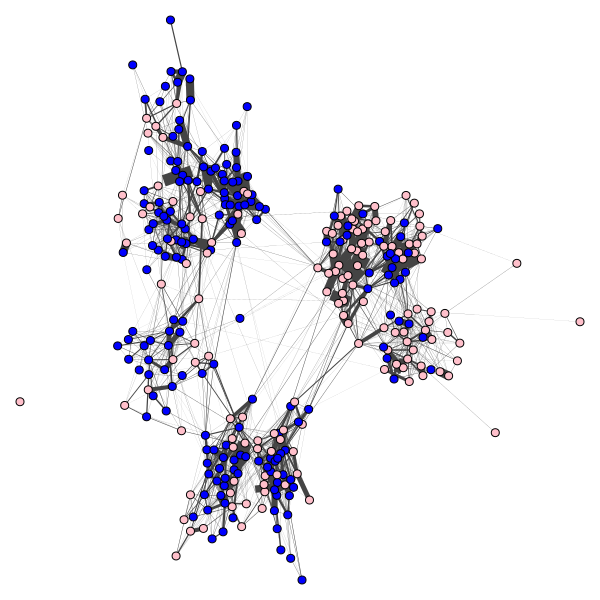

In [9]:
G = ig.Graph.Read('data/sociopatterns.gml')
G = G.clusters().giant()

G.es['width'] = 0.01*np.array(G.es['weight'])
G['layout'] = G.layout_fruchterman_reingold(weights='weight')
G.vs['color'] = ['pink' if v['gender'] == 'F' else 'blue' for v in G.vs]

ig.plot(G, vertex_size=8)

For weighted graphs the weighted degree is called the strength.

In [10]:
strength = G.strength(weights='weight')

In the above plot, the male pupils are colored blue, and the females pink. Now the central question is whether males and femals tend to have more links to the same sex, or more evenly distributed. The more general term for homophily is *assortativity*, which refers to how likely two nodes that have the same attribute are linked. In the plot above it is not immediately clear whether there is gender assortativity (or homophily) in this network. But using a statistical measure of assortativity gives us more insight.

In [11]:
G.assortativity_nominal(ig.VertexClustering.FromAttribute(G, 'gender').membership)

0.17183728104088733

Like a correlation, the assortativity would be 0 if gender would have no relation with the connectivity, 1 if all connections would only be between nodes of the same class and -1 if all connections would only be between nodes of different classes. An assortativity of 0.17 is then not very high, but it does indicate some tendency for pupils of the same sex to be linked.

The pupils mostly associate with other people from the same (school)class. This is again clear from the assortativity based on the (school)class.

In [12]:
G.assortativity_nominal(ig.VertexClustering.FromAttribute(G, 'class').membership)

0.6527202065166847

If we look at the gender assortativity per class this drops to 0. This suggests that the overall assortativity of 0.17 due to gender imbalance in the classes.

In [13]:
classes = ig.VertexClustering.FromAttribute(G, 'class');
for H in classes.subgraphs():
    gender_ratio = sum([v['gender'] == 'F' for v in H.vs])/float(H.vcount())
    gender_assortativity = H.assortativity_nominal(ig.VertexClustering.FromAttribute(H, 'gender').membership)
    print('class: {0},\t% female: {1:.2f},\tassortativity: {2:.3f}'.format(H.vs['class'][0], gender_ratio, gender_assortativity))

class: 2BIO1,	% female: 0.78,	assortativity: 0.021
class: 2BIO2,	% female: 0.59,	assortativity: 0.043
class: 2BIO3,	% female: 0.80,	assortativity: 0.020
class: MP*1,	% female: 0.21,	assortativity: 0.001
class: MP*2,	% female: 0.16,	assortativity: -0.009
class: PSI*,	% female: 0.29,	assortativity: 0.023
class: PC,	% female: 0.41,	assortativity: 0.039
class: PC*,	% female: 0.36,	assortativity: 0.028
class: MP,	% female: 0.33,	assortativity: -0.014


## Social influence

One of the key concepts in social network analysis is social influence. The basic idea is that people that are linked influence each other. For example, if person A holds opinion A but all his neighbors hold opinion B, then he is likely to switch to opinion B. Let us simulate some simple opinion dynamics on the highschool network. We will assume that every node will switch to the majority opinion in its neighborhood, and we will start from some random initial condition.

In [14]:
G = ig.Graph.Read('data/sociopatterns.gml')
G = G.clusters().giant()
G.es['width'] = 0.01*np.array(G.es['weight'])
G['layout'] = G.layout_fruchterman_reingold(weights='weight')

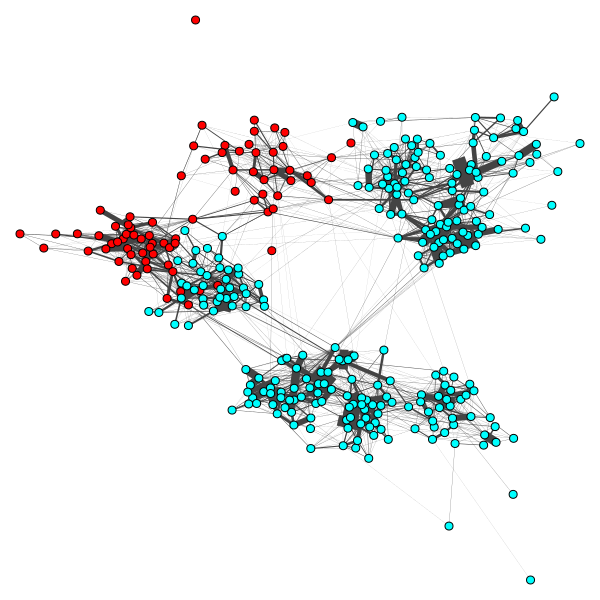

In [15]:
G.vs['opinion'] = 0
G.vs['new_opinion'] = np.random.randint(2, size=G.vcount())

while G.vs['opinion'] != G.vs['new_opinion']:
    G.vs['opinion'] = G.vs['new_opinion']
    for v in G.vs:
        v['new_opinion'] = 1*(sum(G.vs[G.neighbors(v)]['opinion']) > 0.5*v.degree())

ig.plot(G, vertex_color=[int(v['opinion']) for v in G.vs], palette=ig.RainbowPalette(2), vertex_size=8)

One of the problems with social influence is that it usually is confounded with homophily. Let us check if there is assortativity on the result of the opinion dynamics.

In [16]:
G.assortativity_nominal(G.vs['opinion'])

0.7217992925985929

The assortativity on the opinion is roughly the same as the assortativity on the classes. But that begs the question of whether homophily was operating or social influence. The cases here are clear. The class likely influences the probability of a link, so homophily is operating. In the opinion dynamics simulation, we know that the network did not change, but only the opinion did, so there is clear social influence. But if we empirically see that there is some assortativity on some variable, we cannot determine unambiguously whether there is homophily or social influence.

## Centrality

Sometimes, rather than viewing social influence as a process, it is seen as the overall influence some person can exert over others. It is thought that more central persons are generally more influential. In order to sway opinion, you could for example better target the more central person. However, there are several variants of centrality, and all of them have some merit. We will illustrate them on the karate club network again.

In [17]:
G = ig.Graph.Famous('Zachary')
G.vs['color'] = 'gray'
G.es['color'] = 'gray'
G['layout'] = G.layout_auto()

### Degree centrality

The simples is degree centrality, which is nothing more than simply the number of contacts somebody has.

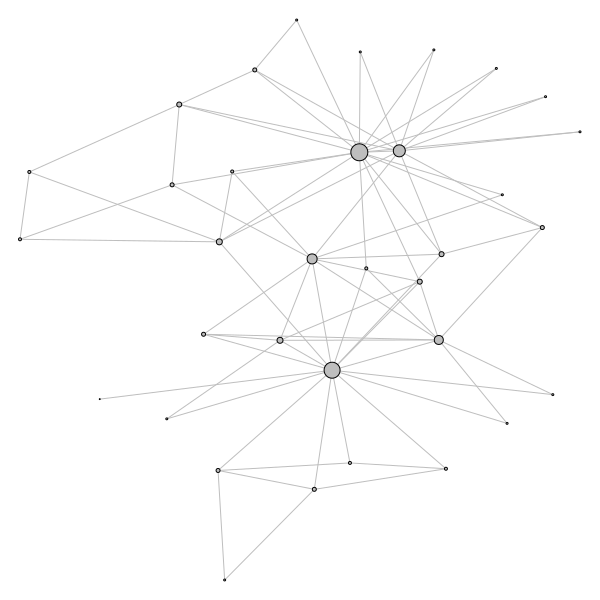

In [18]:
G.vs['centrality'] = G.degree()
ig.plot(G, vertex_size=G.vs['centrality'])

### Eigenvector centrality

The idea of eigenvector centrality is that you are as central as the people you are connected with. So, if you connect to many central people, you should be central yourself. Perhaps this recursive notion of centrality is confusion, but it leads to an elegant solution. If you write out the math, it turns out the largest so-called eigenvector is actually the solution, whence the name.

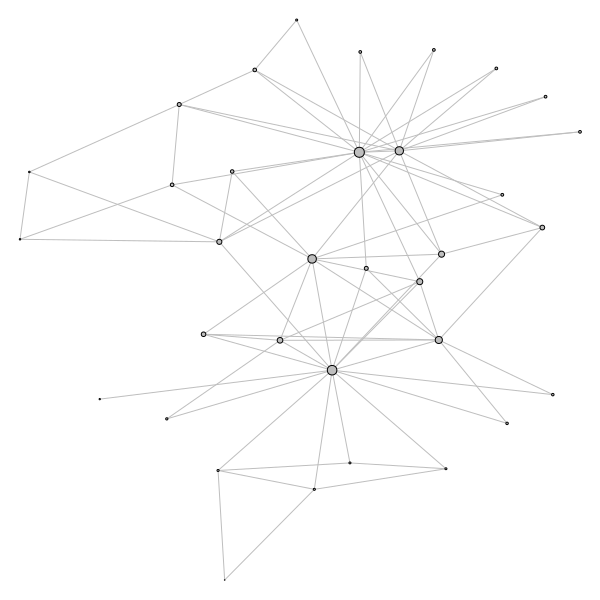

In [19]:
G.vs['centrality'] = G.eigenvector_centrality()
ig.plot(G, vertex_size=10*np.array(G.vs['centrality']))

### Pagerank

One problem with eigenvector centrality is that it is not always well-defined in the case of directed graphs. The interesting thing of eigenvector centrality is that it is similar to the proportion of time spent in a node if a *random walker* would traverse the network, choosing links to follow at random. In directed graphs there may be so-called *sinks*: nodes with no outgoing edges. If you think of a random walker, you can imagine the problem: (s)he gets stuck in a sink. The opposite of *sinks* are called *sources*: nodes with no incoming edge. A random walker would then never arrive in a source.

To alleviate this problem, the idea of *teleportation* was introduced. With a small probability a random walker would start in any other node at random. Hence, from any sink node the walker can then always escape, and there is always a probability (s)he arrives at a source node. This was introduced by the founders of Google to model a *random surfer*, jumping from webpage to webpage and every now and then starting anew. This centrality measure is called pagerank, and it forms the core of Google's search engine.

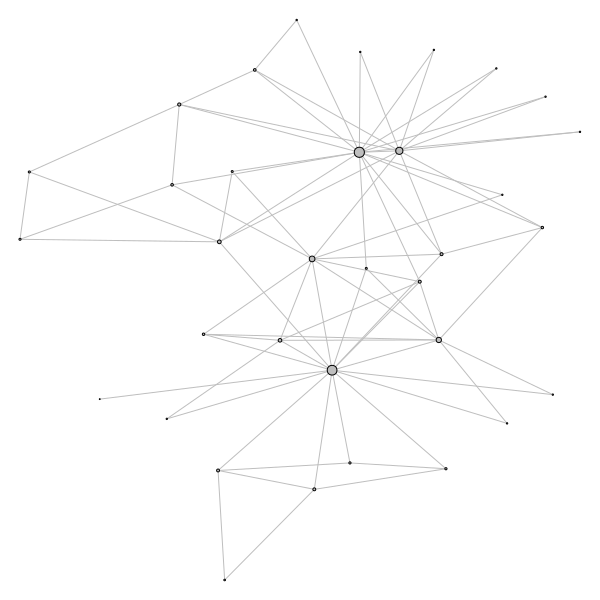

In [20]:
G.vs['centrality'] = G.pagerank()
ig.plot(G, vertex_size=100*np.array(G.vs['centrality']))

### Betweenness centrality

The previous two centralities were based on random walks in a certain sense. Betweenness centrality in contrast uses the shortest path rather than random walks. The fraction of the shortest paths that goes through a certain node is called the betweenness centrality.

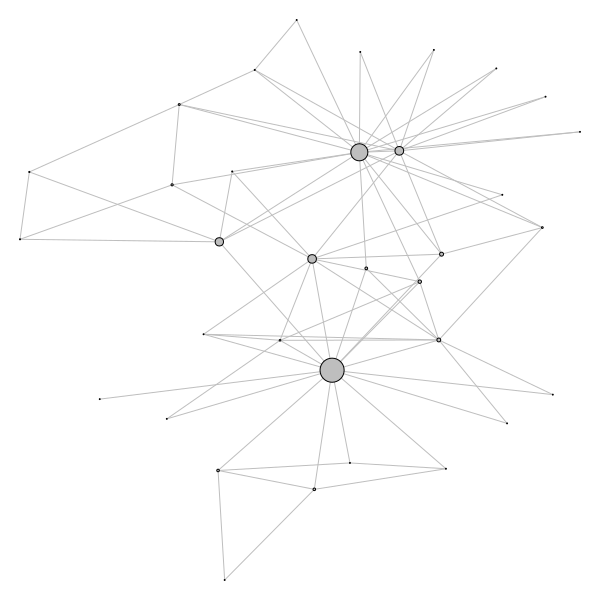

In [21]:
G.vs['centrality'] = G.betweenness(G.vs)
ig.plot(G, vertex_size=0.1*np.array(G.vs['centrality']) + 1)

As you can see, most centralities tend to give relatively similar results, but there can be some variation.

## Weak ties

There are two main ideas associated with the so-called strenght of weak ties (i.e. links of low weight). The first is that weak ties hold together the network. The second is that new information is obtained through weak ties. The first can be studied relatively easily on any given weighted network. The second is more difficult, and is less frequently studied, because it also requires observations on information sharing.

The idea that weak ties hold together the network can be studied in two contexts. One straightforward possibility is that if we cut weak ties we relatively quickly disconnect the network. Another possibility is that weak ties mostly fall between groups of people. Finally, it is often also analysed whether weak ties mostly fall between nodes that have relatively few common neighbors.

We will study this using the highschool network.

In [22]:
G = ig.Graph.Read('data/sociopatterns.gml')
G = G.clusters().giant()
G['layout'] = G.layout_fruchterman_reingold(weights='weight')
G.es['width'] = 0.01*np.array(G.es['weight'])

Let us see where the weak links are in the network. We will see all links with weights below the average as weak links.

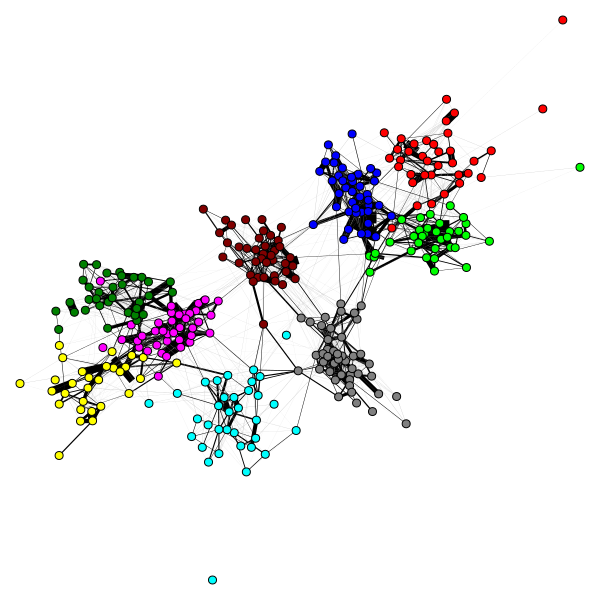

In [23]:
class_partition = ig.VertexClustering.FromAttribute(G, 'class')  
ig.plot(class_partition, 
        edge_color=['gray' if e['weight'] < np.mean(G.es['weight']) else 'black' for e in G.es],
        vertex_size=8)

The weak links appear to fall between the different classes, while the stronger links are more likely to be found within the classes. This can easily be computed.

In [24]:
is_crossing_edge = class_partition.crossing()
weight_between = np.mean([e['weight'] for e in G.es if is_crossing_edge[e.index]])
weight_within = np.mean([e['weight'] for e in G.es if not is_crossing_edge[e.index]])
print('Weight within {0:.2f}, between {1:.2f}.'.format(weight_within, weight_between))

Weight within 43.68, between 6.88.


This suggests that if we delete the weak links first, we disintegrate the network. Let us delete edges from the graph in two different orders: the weakest edges first or the strongest edges first. We look at whether there is a clear giant component, or whether the network splits into more equally sized components.

In [25]:
H = G.copy()
weak_component_size = [];
while H.ecount() > 0:
    H.delete_edges(min(H.es, key=lambda e: e['weight']))
    #weak_component_size.append(H.clusters().giant().vcount())
    cl = H.clusters()
    weak_component_size.append(sum(np.array(cl.sizes())**2) - cl.giant().vcount()**2)
    
H = G.copy()
strong_component_size = [];
while H.ecount() > 0:
    H.delete_edges(max(H.es, key=lambda e: e['weight']))
    #strong_component_size.append(H.clusters().giant().vcount())    
    cl = H.clusters()
    strong_component_size.append(sum(np.array(cl.sizes())**2) - cl.giant().vcount()**2)

Plotting the results shows that the deleting the weak edges first tends to have a quite different effect than deleting the strong edges first.

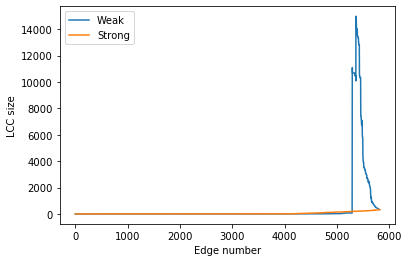

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(weak_component_size, label='Weak')
plt.plot(strong_component_size, label='Strong')
plt.xlabel('Edge number')
plt.ylabel('LCC size')
plt.legend(loc='best');

The plot may be a bit obscure. Inspecting the actual resulting networks after deleting a critical amount of edges may be more revealing.

In [27]:
break_point = np.array(weak_component_size).argmax()

Let us first look at the network if we remove the strong links first. It is clear that this network has a single giant component, which is only connected through weak links, and many isolated nodes.

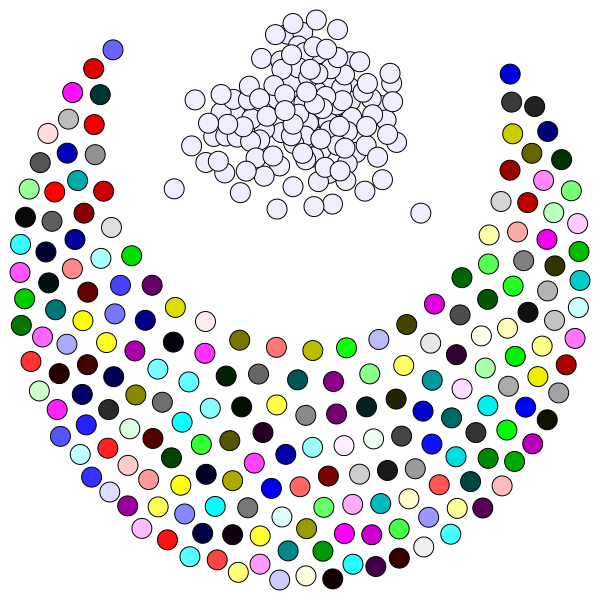

In [28]:
H = G.copy()
del H['layout']
H.delete_edges(sorted(H.es, key=lambda e: e['weight'], reverse=True)[:break_point])
ig.plot(H.clusters())

This contrasts sharply to the network if we remove the weak links first. We can clearly see that it seperates into several smaller sizeable components.

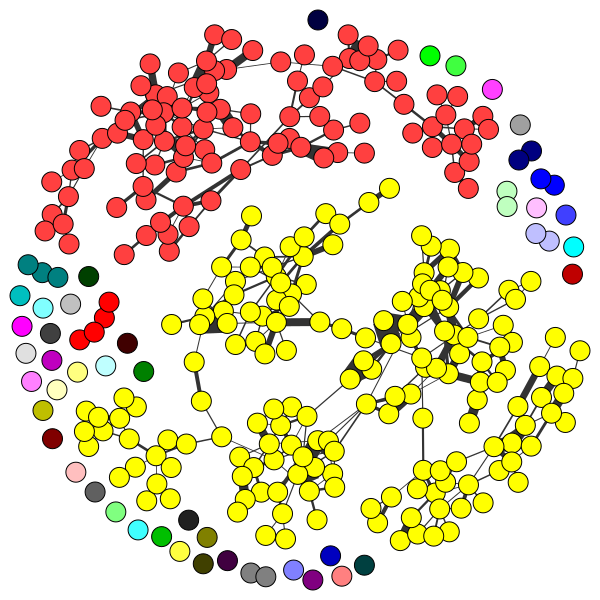

In [29]:
H = G.copy()
del H['layout']
H.delete_edges(sorted(H.es, key=lambda e: e['weight'])[:break_point])
ig.plot(H.clusters())

Finally, we can also check if strong links tend to occur between people that have a high overlap of common neighbors. This overlap is usually calculated as the Jaccard similarity.

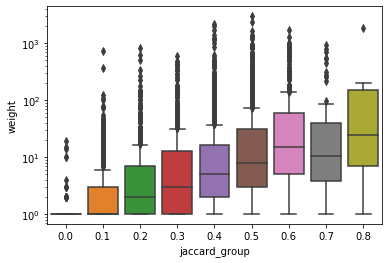

In [30]:
jaccard_similarity = G.similarity_jaccard(pairs=G.get_edgelist());
df = pd.DataFrame({'jaccard': jaccard_similarity, 
                   'weight': G.es['weight']})
df['jaccard_group'] = np.round(df['jaccard'], 1)

sns.boxplot(x='jaccard_group', y='weight', data=df)
plt.yscale('log')

## Structural holes

When nodes have a high clustering coefficient, they are often thought to be well *embedded* in the network. People in such a position in the network tend to have friends that are also friends themselves. In a certain sense, they are in a *cohesive* environment. This is generally thought to increase trust in one another, but also tends to be associated with higher peer pressure and social norm enforcement.

Node that have a low clustering coefficient occupy a rather different position in the network. They tend to connect different parts of the network, and we earlier saw that they tend to act as bridges. This notion of a bridge can be a bit relaxed to a *local bridge*: an edge without common neighbors, or stated differently a jaccard similarity of 0.

Nodes with such a position are said to "fill" a *structural hole*. They are the go-between for different people, providing such strutural holes with a strategic advantage. For example, a real-estate agent may facilitate a transaction between a buyer and a seller. Neither buyer nor seller would be connected if it wasn't for the real-estate agent. Indeed, people in such a position of a *structural hole* are sometimes also called *brokers*.

Structural holes are also thought to have more opportunities for innovation and creativity. At the interface of different groups, people occupying structural holes may hear much more, and diverse, information. This could enable them to integrate this diverse information into something new.

Let us identify the brokers in the highschool network.

In [31]:
G = ig.Graph.Read('data/sociopatterns.gml')
G = G.clusters().giant()
G['layout'] = G.layout_fruchterman_reingold(weights='weight')
G.es['width'] = 0.01*np.array(G.es['weight'])

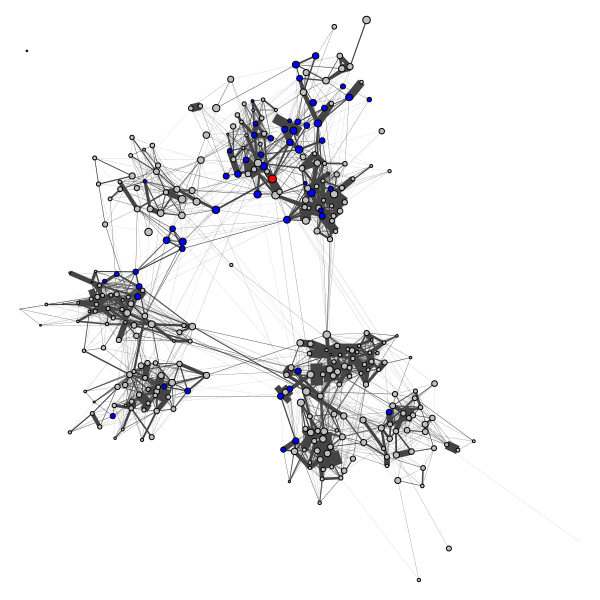

In [32]:
G.vs['clustering'] = G.transitivity_local_undirected()
most_broker = min(G.vs, key=lambda v: v['clustering'])

G.vs['color'] = 'gray'
most_broker['color'] = 'red'
G.vs[G.neighbors(most_broker)]['color'] = 'blue'

ig.plot(G, vertex_size=10.0*(1 - np.array(G.vs['clustering'])))

As can be seen, the node with the lowest clustering tends to connect people from across the network. This contrasts to a node with a higher clustering (but at least as many neighbors).

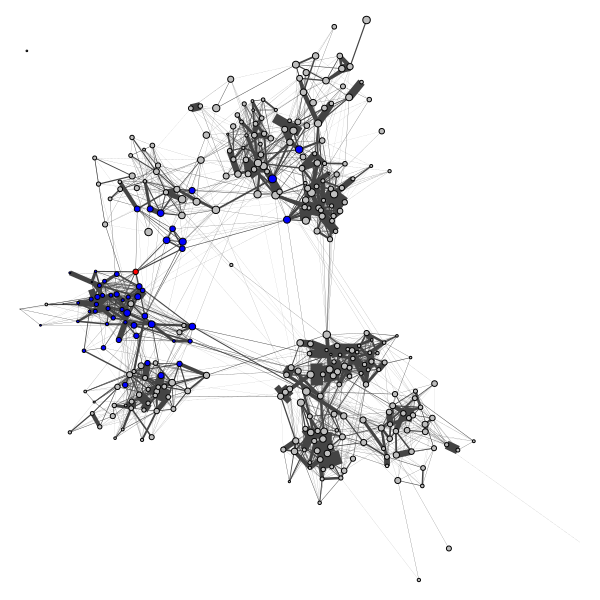

In [33]:
least_broker = max(G.vs.select(_degree_ge=most_broker.degree()), key=lambda v: v['clustering'])
                   
G.vs['color'] = 'gray'
least_broker['color'] = 'red'
G.vs[G.neighbors(least_broker)]['color'] = 'blue'

ig.plot(G,vertex_size=10.0*(1 - np.array(G.vs['clustering'])))

We can make this more explicit. We can calculate the dispersion of neighbors across different classes in the network as the entropy. A higher entropy indicates that the neighbors are more equally distributed across the network, whereas a lower entropy indicates that the neighbors are mostly concentrated in a few classes.

Text(0, 0.5, 'Entropy')

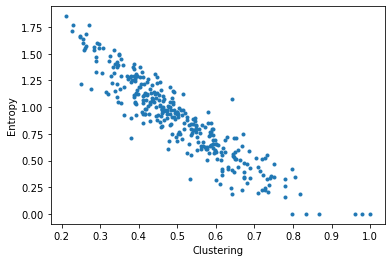

In [34]:
from collections import Counter

def entropy(lst):
    freq = Counter(lst);
    prob = [float(f)/len(lst) for f in freq.values()]
    return -sum(prob*np.log(prob))

entropy_node = [entropy(G.vs[G.neighbors(v)]['class']) for v in G.vs];

plt.plot(G.vs['clustering'], entropy_node, '.')
plt.xlabel('Clustering')
plt.ylabel('Entropy')

## Equivalence

People occupy different positions in a network. We already saw brokers for example. This idea can be somewhat generalized to the notion of equivalence. The most strict definition of equivalence between two nodes is if they share the exacte same neighbors, called *structural equivalence*. A slightly more relaxed definition is that of *isomorphic equivalence*, meaning that switching the labelling does not change the structure of the graph. This is still quite restrictive actually, and hard to compute.

The most relaxed definition is *regular equivalence*, which considers two nodes as equivalent if they connect to similar others. For example, employees report to their managers who report to the board. Then all managers occupy a regularly equivalent position: they connect to employees and board members. Similarly all employees are regularly equivalent: they all report to managers (even though they don't necessarily report to the same manager). This is a recursive definition, and also is relatively difficult to compute. 

Of course exact regular equivalence may not be the most informative, so some trade-off between the number of 'errors' (i.e. deviating from the other members of the equivalence class) may be tolerated. This is sometimes also referred to as *role detection* as a generalization of *community detection* which we will encounter later on.

Unfortunately there are currently no implementations available for `igraph`, and in fact, no implementations for Python that I know of.

## Social balance

Social balance does not refer to some zen concept of balance or a state of peace. If anything, it actually has more to do with conflict than with peace. Social balance is a theory regarding the structure of *negative links*, i.e. links that have a negative connotation, such as hate or war. These can either be presented as a separate type of link, or as links having some continuous weight, which may also be negative. 

The basis of the theory is that if two nodes are positively connected, they must be similarly connected to another third party: either both should have positive relations or both should have negative relations. The following two triads are socially balanced.

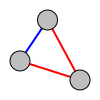

In [35]:
H = ig.Graph.Full(3)
H.es['weight'] = [1, -1, -1]
ig.plot(H, bbox=[0, 0, 100, 100], vertex_color='gray', edge_width=2, 
        edge_color=['blue' if e['weight'] > 0 else 'red' for e in H.es])

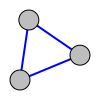

In [36]:
H = ig.Graph.Full(3)
H.es['weight'] = [1, 1, 1]
ig.plot(H, bbox=[0, 0, 100, 100], vertex_color='gray', edge_width=2, 
        edge_color=['blue' if e['weight'] > 0 else 'red' for e in H.es])

The following two triads are then *unbalanced*.

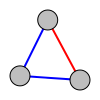

In [37]:
H = ig.Graph.Full(3)
H.es['weight'] = [1, 1, -1]
ig.plot(H, bbox=[0, 0, 100, 100], vertex_color='gray', edge_width=2, 
        edge_color=['blue' if e['weight'] > 0 else 'red' for e in H.es])

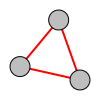

In [38]:
H = ig.Graph.Full(3)
H.es['weight'] = [-1, -1, -1]
ig.plot(H, bbox=[0, 0, 100, 100], vertex_color='gray', edge_width=2, 
        edge_color=['blue' if e['weight'] > 0 else 'red' for e in H.es])

The idea of social balance is that the triads that are unbalanced are also unstable and tend to disappear, whereas the triads that are balanced tend to be stable. Note that the product of the weights of the stable triads is always positive. If all cycles have such a positive product of the weights, the whole network is said to be balanced (but this rarely happens). But if a network is balanced, something interesting happens: the network splits in two mutually antagonistic factions.

Let us explore this in a network of international (conflict) relations from 2000-2015. This network both contains conflicts and alliances, where the conflicts are negatively weighted, and the alliances positively weighted. 

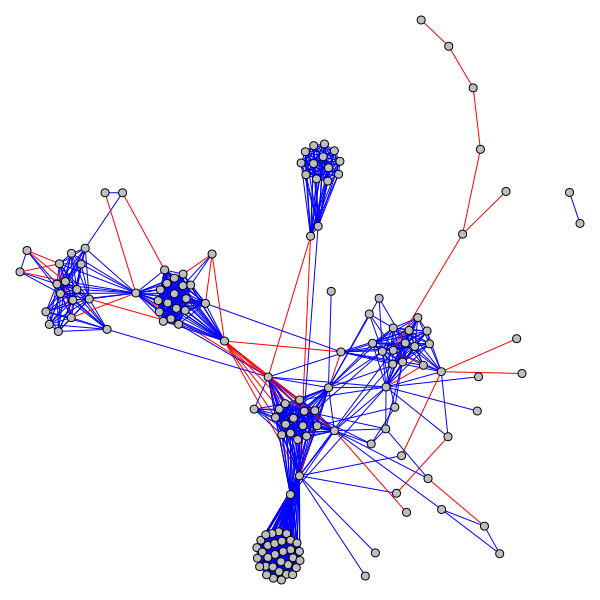

In [39]:
G = ig.Graph.Read('data/international_relations_2000_2015.gml')

G['layout'] = G.layout_fruchterman_reingold()
ig.plot(G, vertex_color='gray', vertex_size=8, 
        edge_color=['blue' if e['weight'] > 0 else 'red' for e in G.es])

Let us explore what the triads look like in this international network.

In [40]:
triads = []
def store_signs(H, v, i):
    # Only store the complete triad
    if (H.vs[v].subgraph().ecount() == 3):
        triads.append( (v, 
                        np.product(H.vs[v].subgraph().es['weight'])
                       )
                     )
    return 0
G.motifs_randesu(callback=store_signs)

Let us see how many triads are found in this network.

In [41]:
len(triads)

9285

Now let us see which triads have a negative sign, and are hence unbalanced.

In [42]:
len([t for (t, s) in triads if s < 0])

42

Let us examine one such unbalanced triad:

In [43]:
t = next(t for (t, s) in triads if s < 0)
H = G.vs[t].subgraph()
[(H.vs[e.source]['StateNme'], H.vs[e.target]['StateNme'], e['weight']) for e in H.es]

[('United States of America', 'Iran', -0.333333),
 ('United States of America', 'Pakistan', 0.126984),
 ('Iran', 'Pakistan', 0.142857)]

In this case, the US is in conflict with Iran, but is allied with Pakistan, while Pakistan is allies with Iran. As you can already sense, this creates some tension: one of the three countries is likely to revise their relations. Either the US becomes allied to Iran (perhaps an unlikely scenario), or comes in conflict with Pakistan. Or Pakistan also enters in conflict with Iran.